Data from the experiment on 2021/05/06: this file puts data in channels * cycles * z * y * x

# Preprocessing

In [1]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
# import tifffile as tif
# import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage
# from skimage.filters import threshold_yen
# import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting

In [2]:
n_channels = 2
n_cycles = 5

with open('./data/registered20210714_sg2NEB.npy', 'rb') as f:
    X = np.load(f)

# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle0.tiff')
# img_size = img.shape[:2]

# X = np.zeros((n_channels*n_cycles, 1, *img_size))
# k = 0
# for i in range(n_channels):
#     for j in range(n_cycles):
#         fn = f'./data/crisprmap20210506/amp-ch{i+1}-cycle{j}.tiff'
#         print(fn)
#         img = tif.imread(fn)
#         X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
#         k = k+1

In [3]:
X.shape

(10, 1, 2048, 1280)

In [4]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

In [5]:
# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle2.tiff')
# plt.figure(dpi=100)
# plt.imshow(img[80:100, 80:100, 1])
# plt.axis('image')
# # im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

In [26]:
up = 0
down = 1800
left = 10
right = 1150

Xcenter = X[:, :, up:down, left:right] # range is selected based on observation of images

In [7]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

# Codebook

The most important is to make sure the codebook and the images are of the same order

In [8]:
# !! currently the first value shows nan and hard code it to be 1; needs a better fix
codebook = np.genfromtxt('./data/CRISPRmap_pilot_codebook_default.csv', filling_values=1, dtype=np.int, delimiter=",")
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [9]:
# codebook = csv.reshape((10, 2, 5)).T.astype(bool)
# codebook

In [10]:
codebook.shape

(10, 10)

The order of the codebook matches the order of the image stack.

## Background subtraction and normalization

In [11]:
Xcenter.shape

(10, 1, 1800, 880)

In [27]:
# Different from how bardensr did it (use these functions for now because they are tested)
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [13]:
Xnorm.shape

(10, 1, 1800, 880)

In [14]:
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xnorm[i, 0,])

## Distribution

In [15]:
# # create the histogram
# for i in range(Xnorm.shape[0]):
#     histogram, bin_edges = np.histogram(Xnorm[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

## Thresholding

In [16]:
Xnorm.shape

(10, 1, 1800, 880)

In [17]:
Xnorm[0, 0,].shape

(1800, 880)

In [18]:
# # Before
# for i in range(Xnorm.shape[0]):
#     histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
#     plt.title(i+1)
#     plt.xlabel("value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

In [28]:
upper = [0.9, 0.9, 0.8, 0.6, 0.5, 0.2, 0.3, 0.1, 0.2, 0.015]
# lower = [0.2, 0.16, 0.13, 0.15, 0.16, 0.16, 0.16, 0.13, 0.15, 0.15]
Xthresh = Xnorm.copy()
for i in range(Xthresh.shape[0]):
    single = Xthresh[i, 0,]
#     single[single < lower[i]] = 0
    single[single > upper[i]] = upper[i]
    Xthresh[i, 0] = single
    
Xthresh = bardensr.preprocessing.minmax(Xthresh)

In [20]:
# # After
# for i in range(Xthresh.shape[0]):
#     histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
#     plt.title(i+1)
#     plt.xlabel("value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

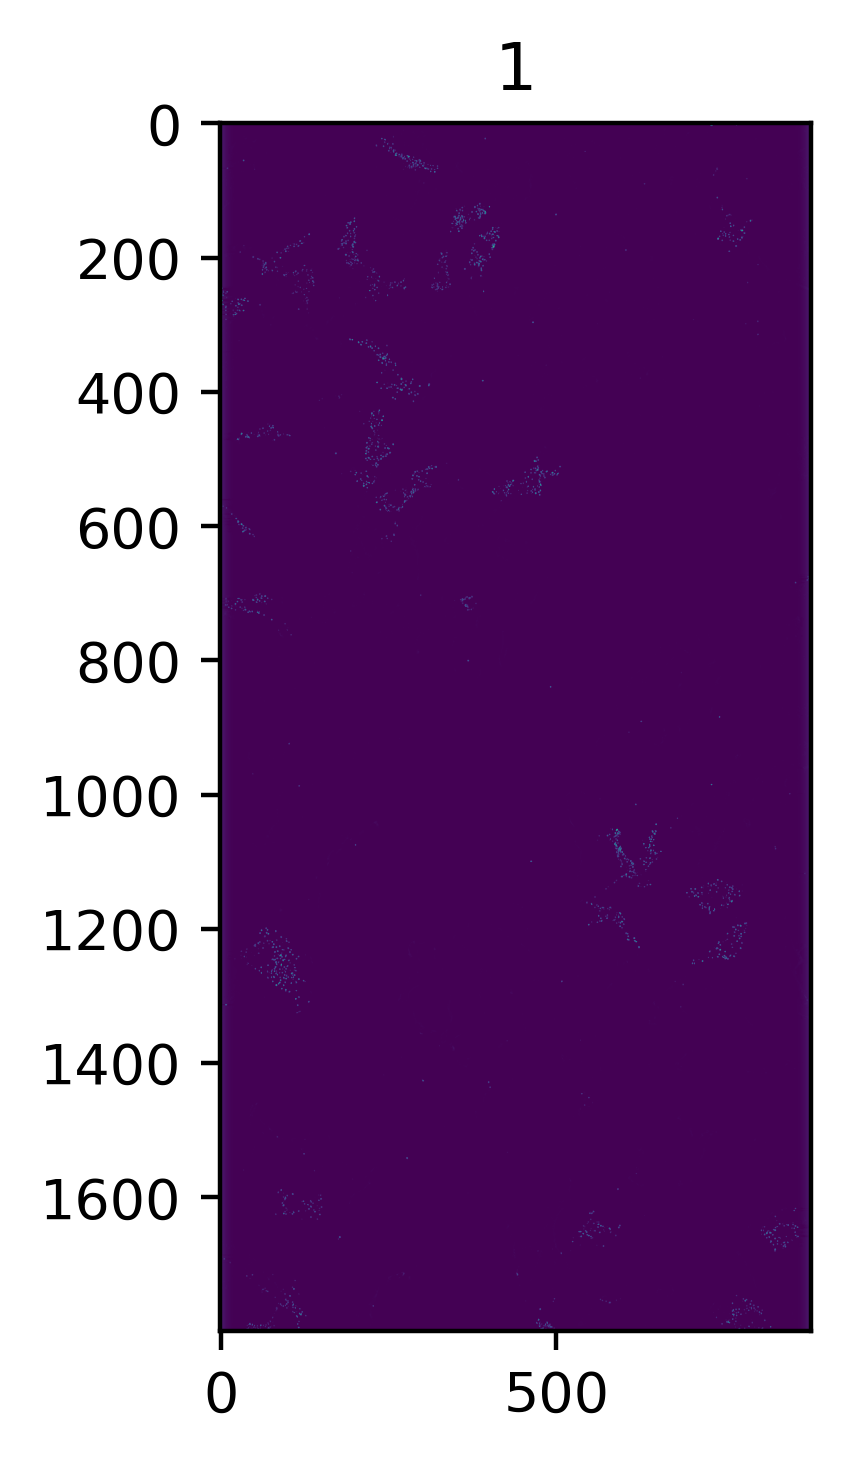

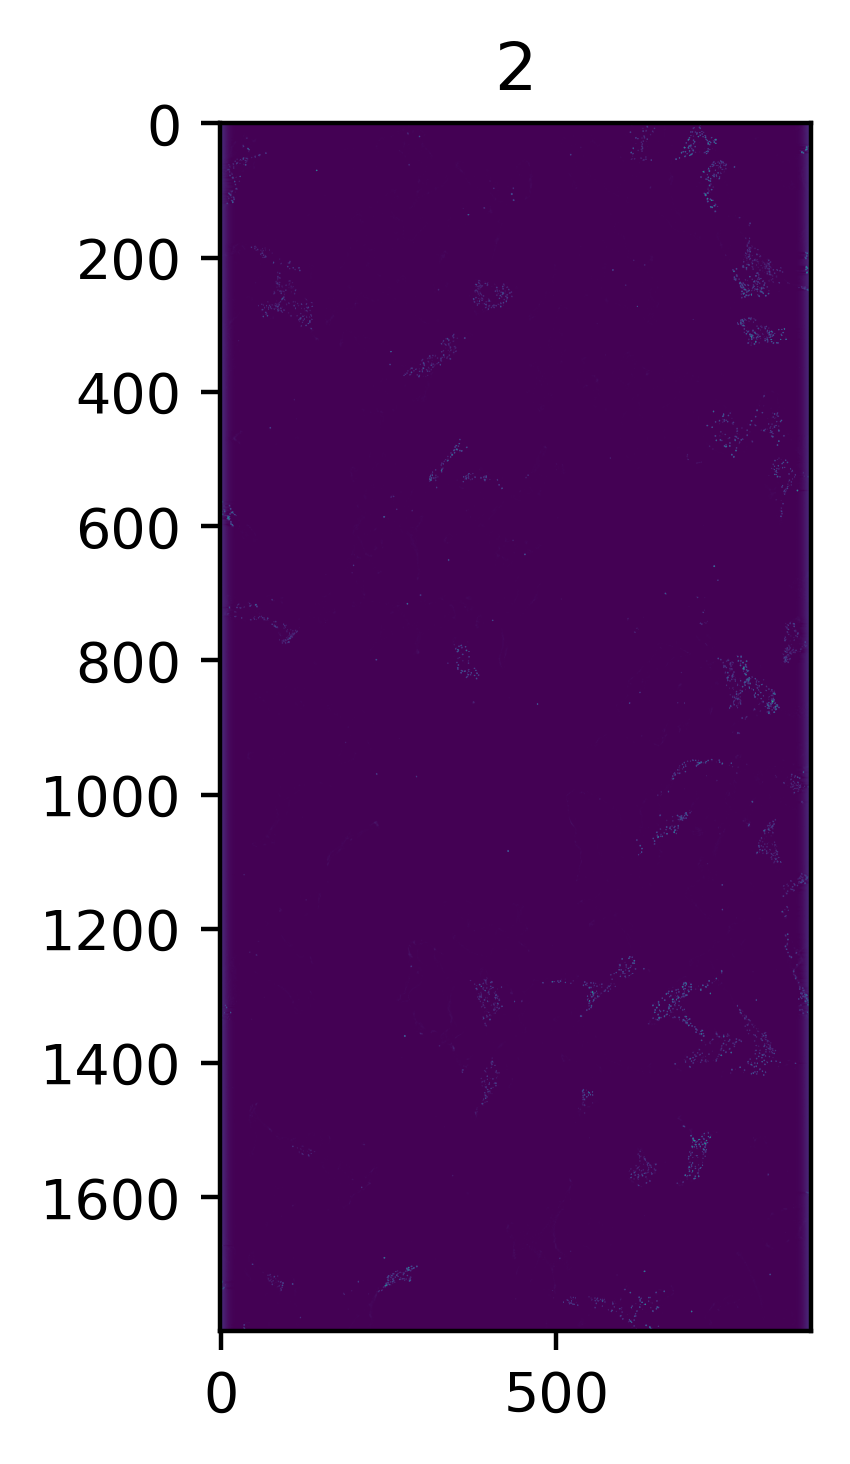

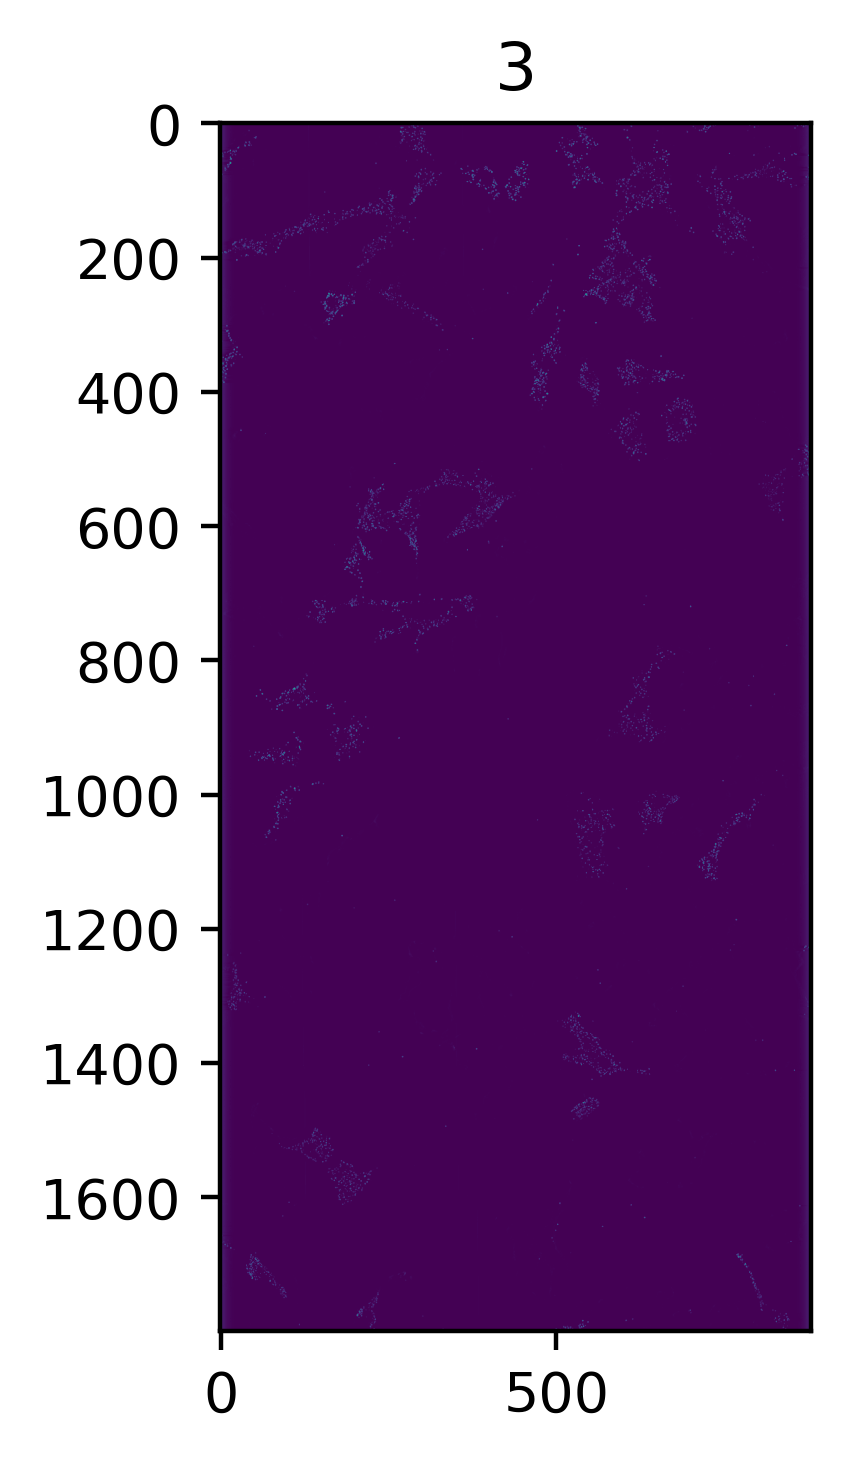

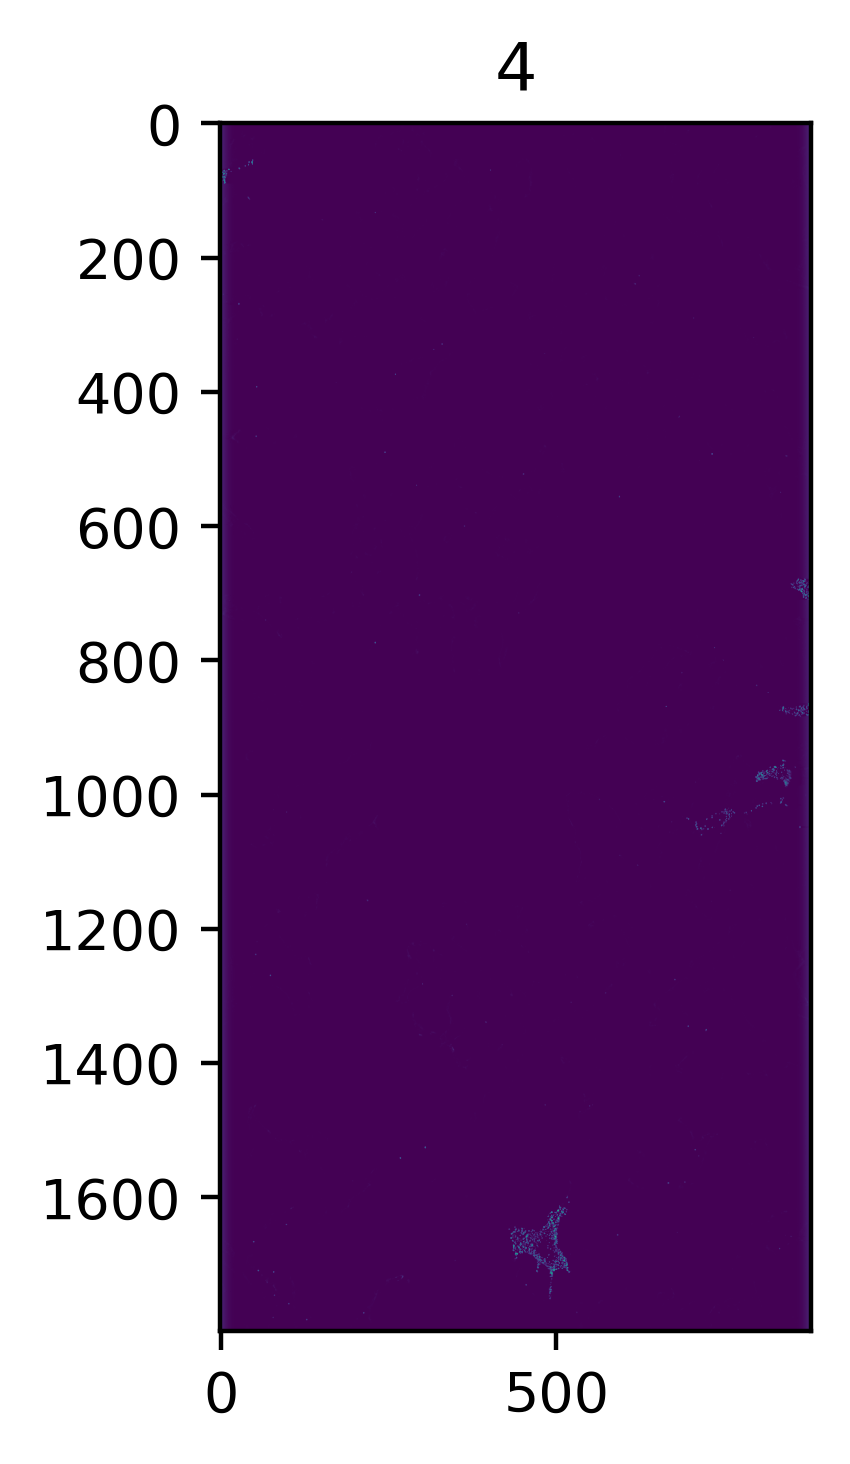

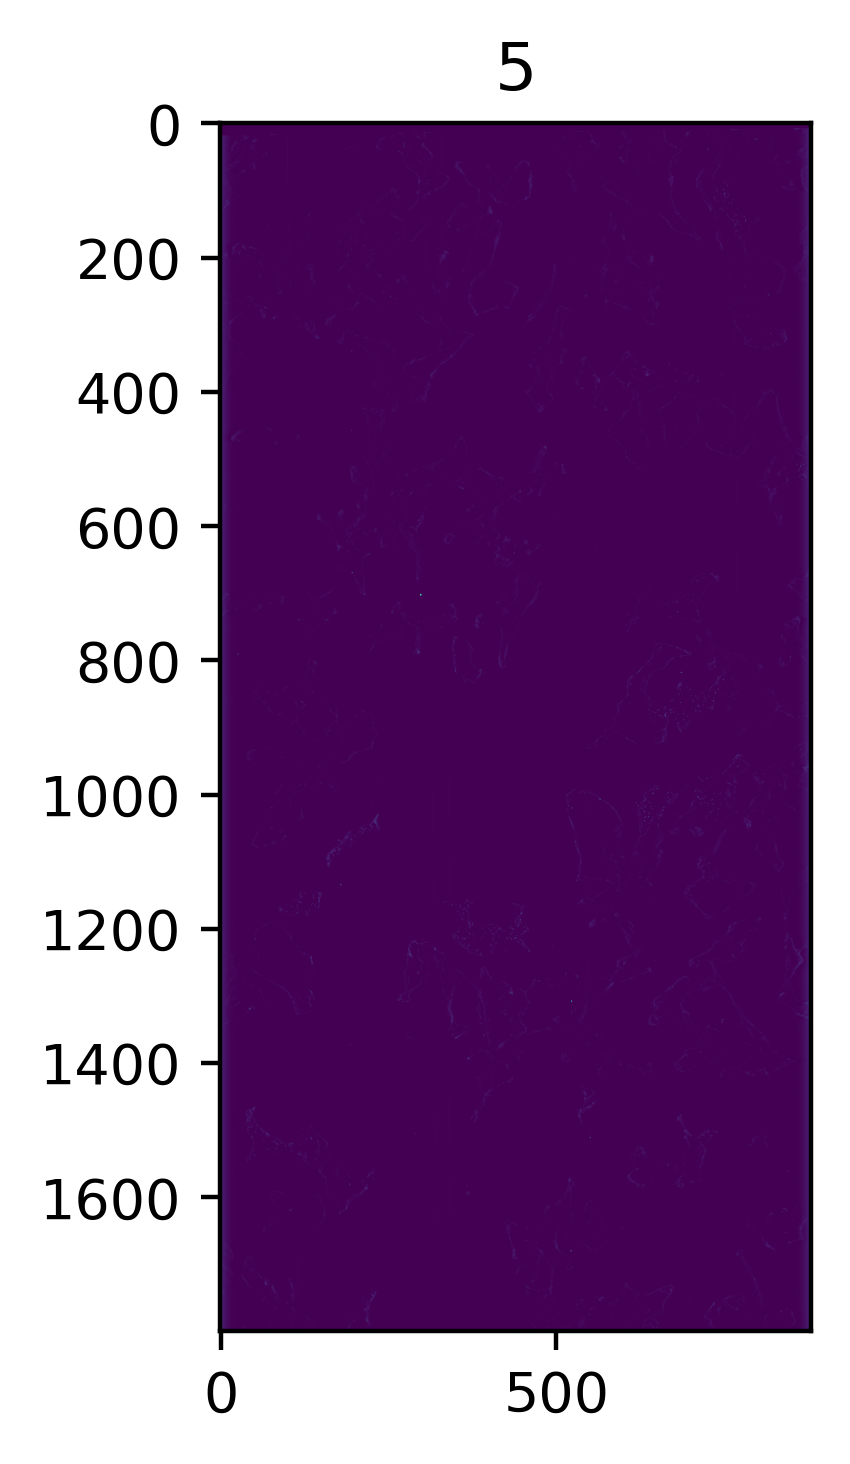

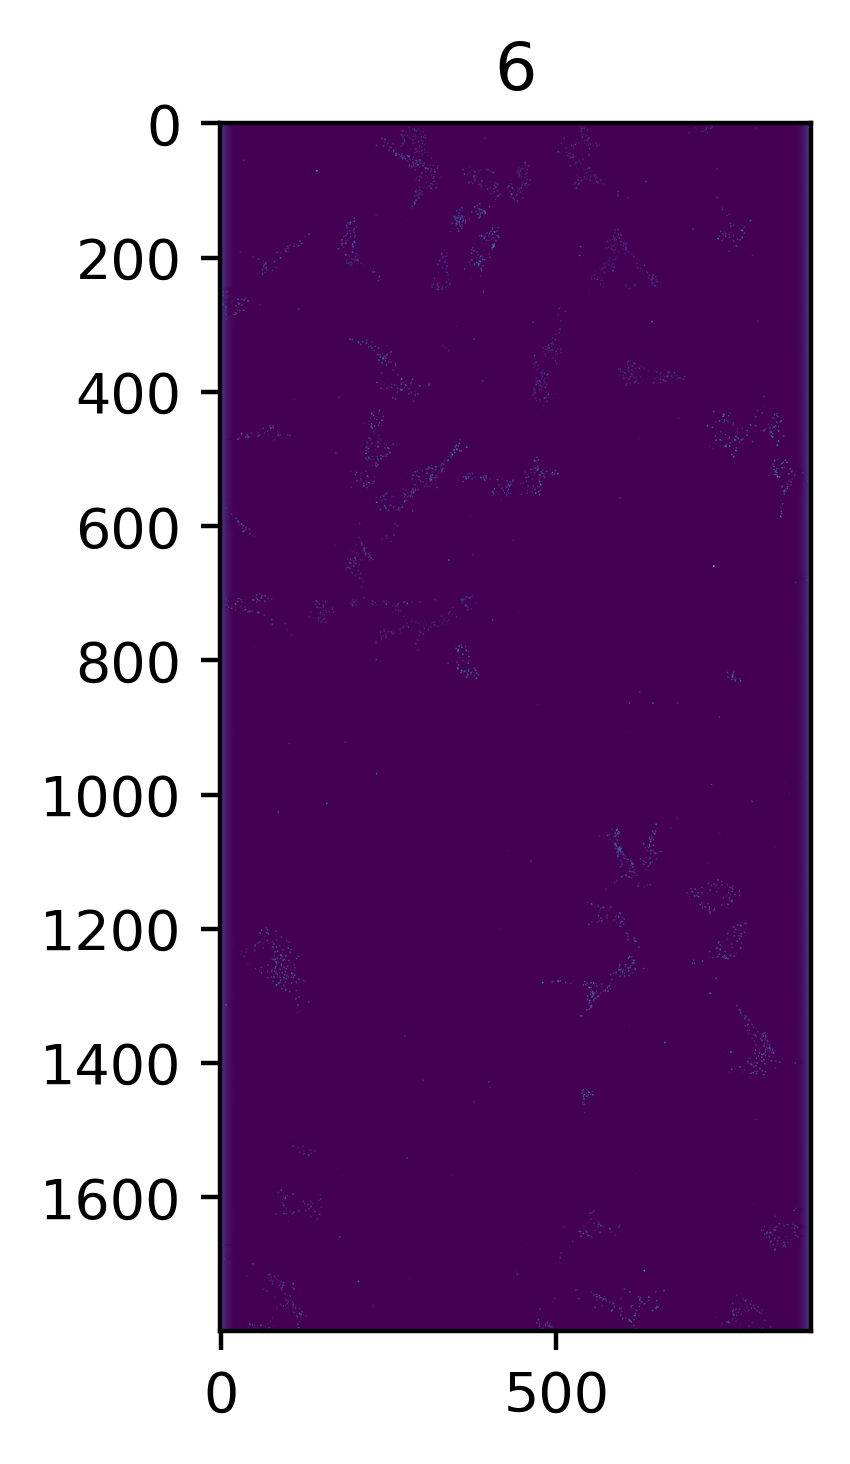

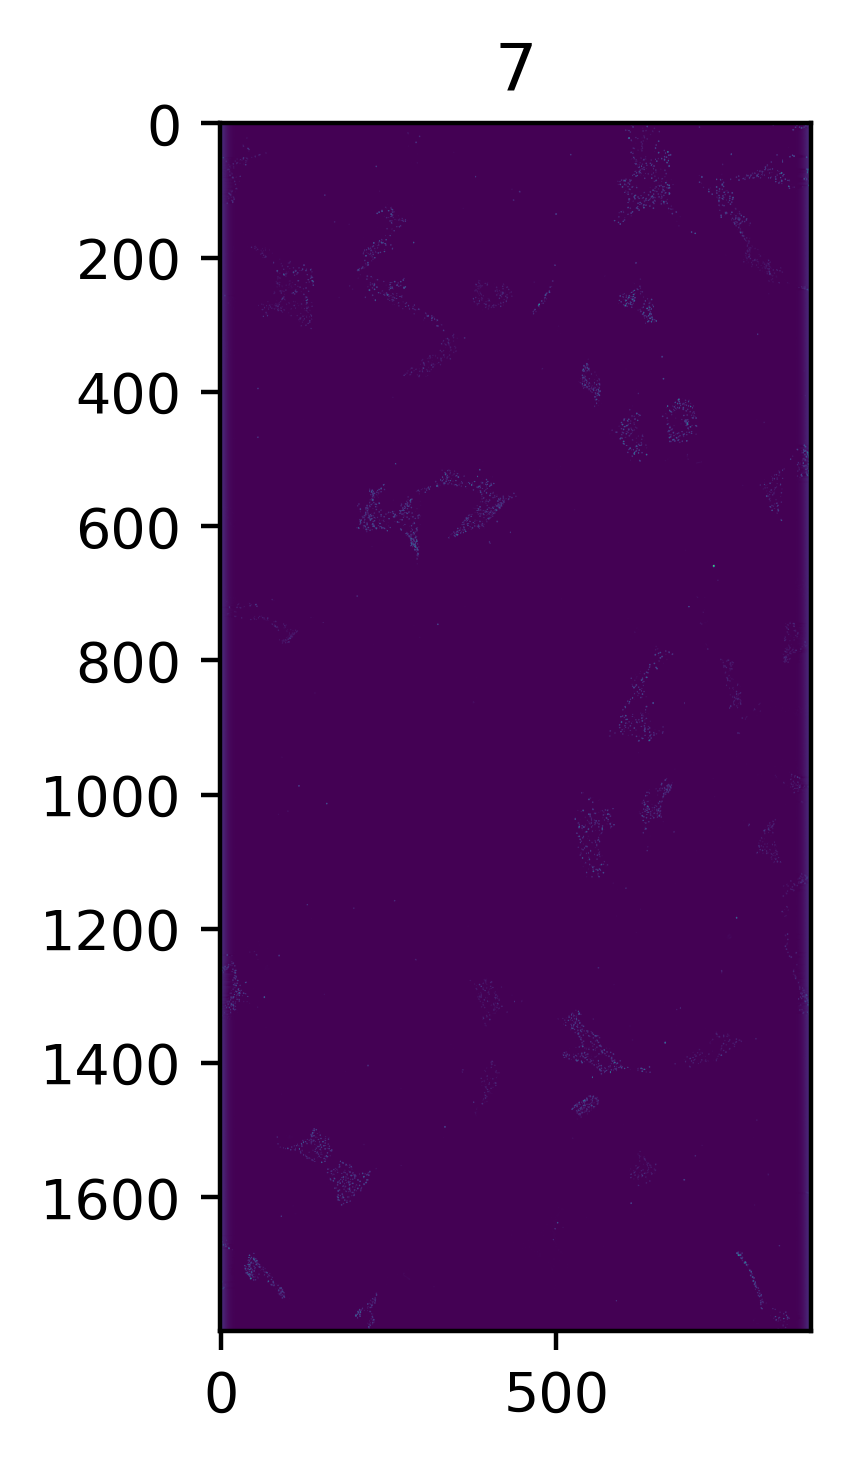

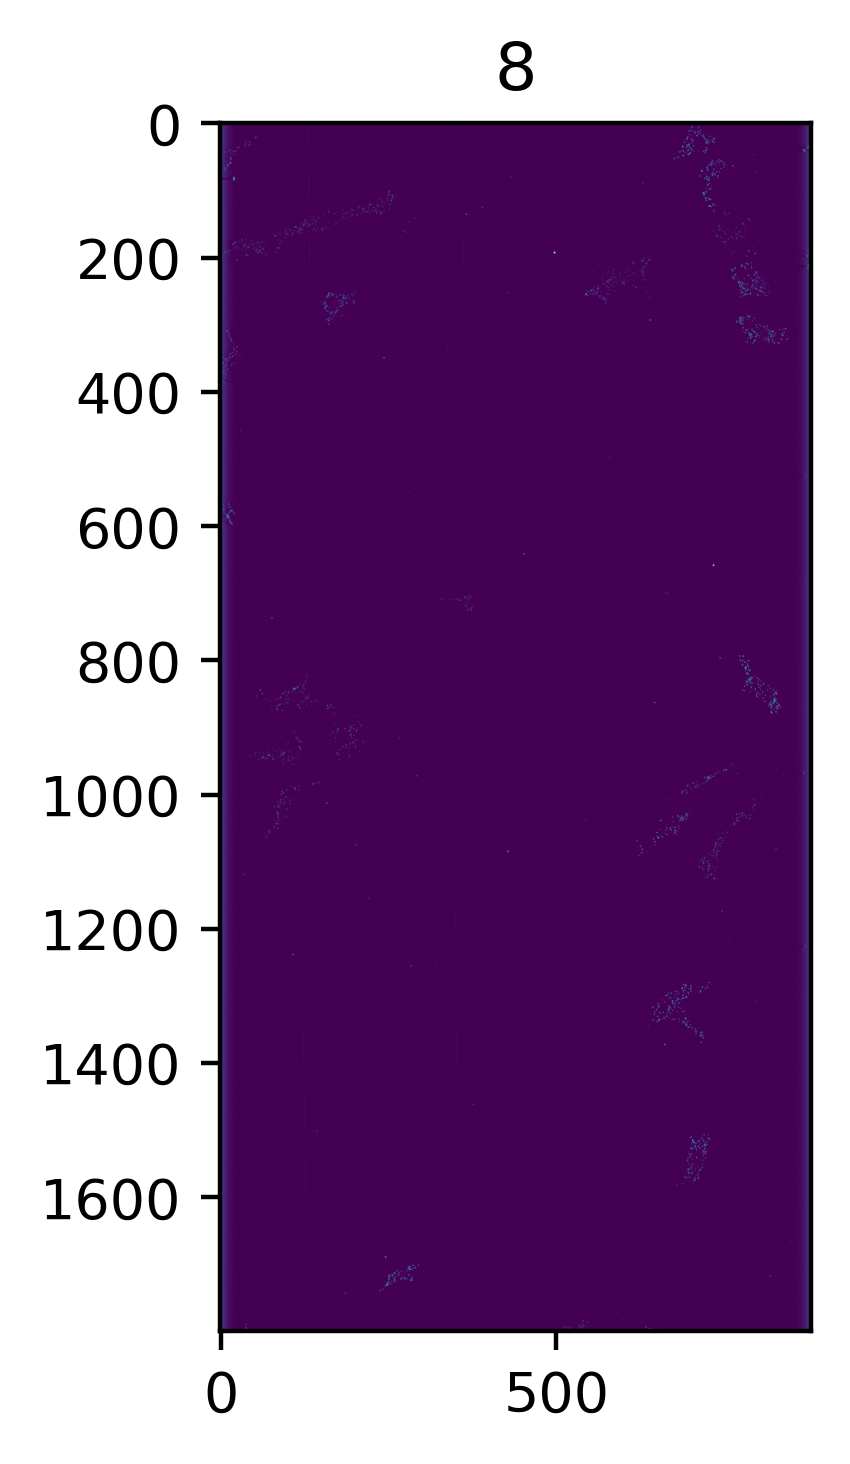

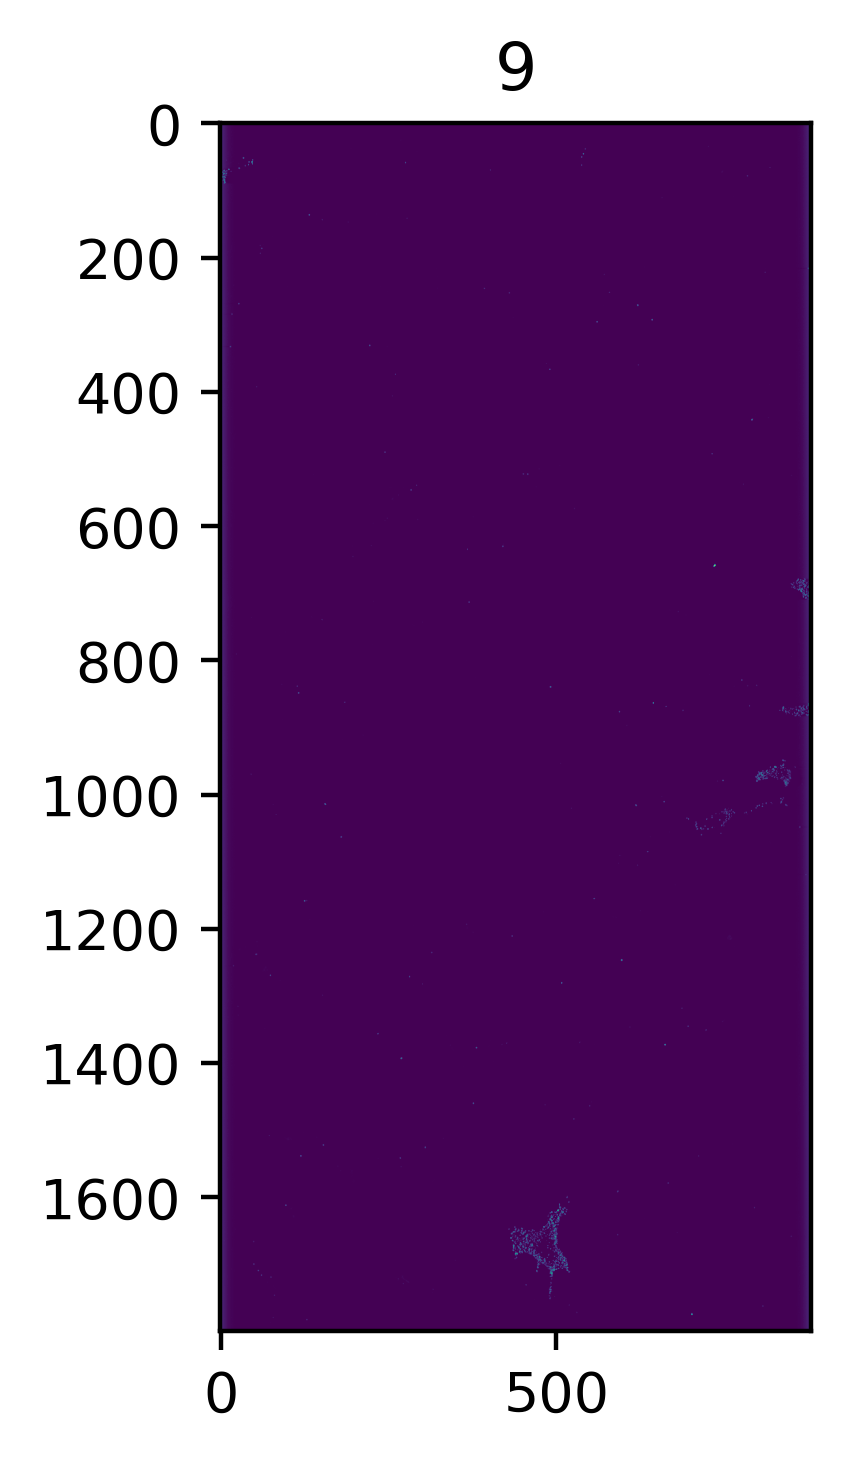

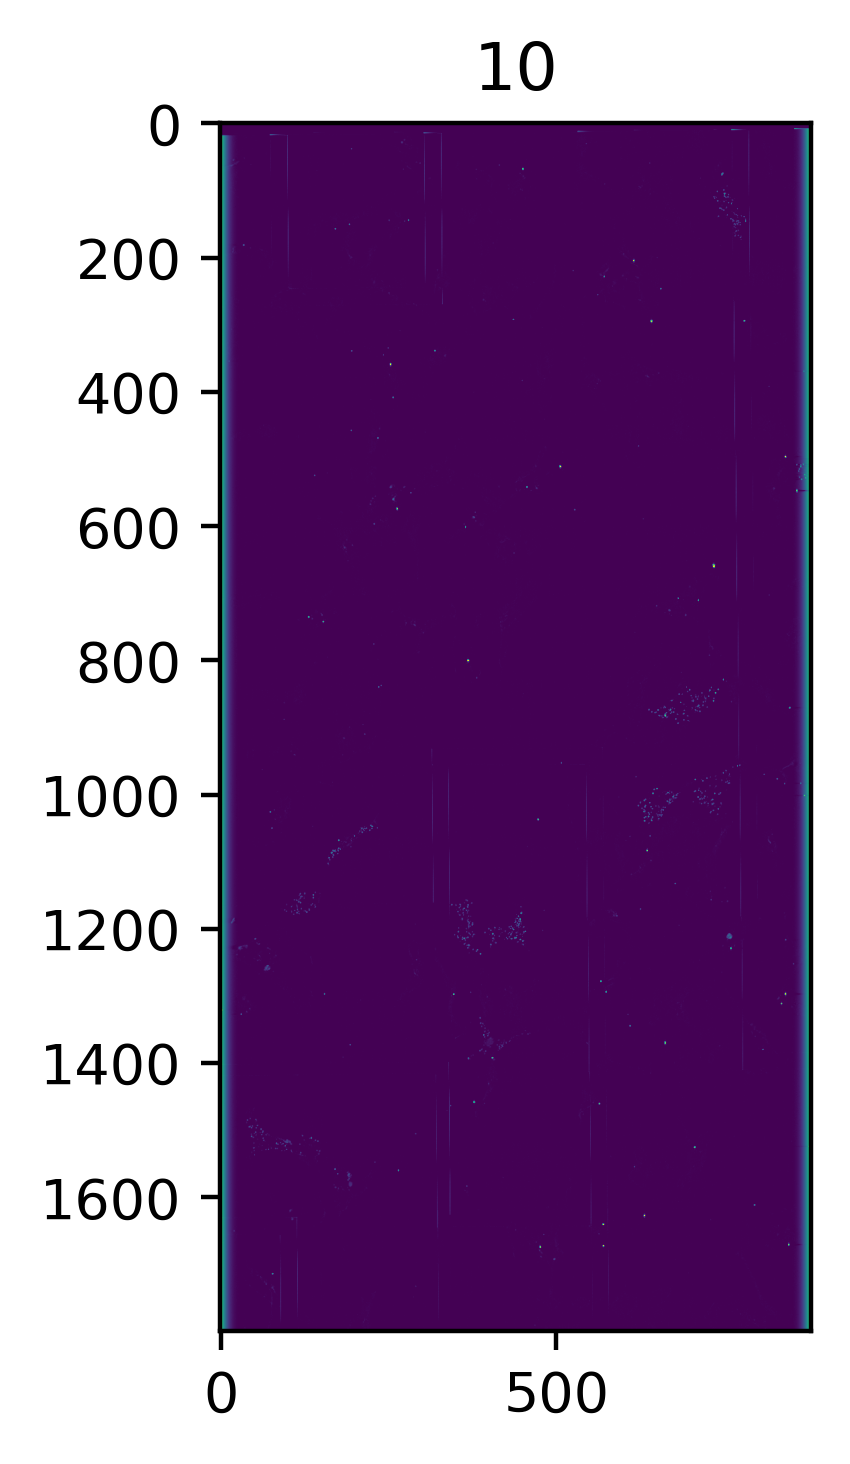

In [21]:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=400)
#     plt.imshow(Xthresh[i, 0])
#     plt.title(i+1)

In [22]:
# residual = 0.05  # tested through the spot method and the cell method should be less sensitive 
# Xthresh = Xnorm.copy()
# Xthresh[Xthresh < residual] = 0

In [23]:
# # Using threshold Yen on Xnorm
# Xthresh = np.zeros(Xnorm.shape)
# for i in range(Xnorm.shape[0]):
#     image = Xnorm[i, 0, ]
#     thresh = threshold_yen(image)
#     binary = image > thresh
#     Xthresh[i, 0, ] = binary
    
#     plt.figure(dpi=500)
#     fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
#     ax = axes.ravel()

#     ax[0].imshow(image)
#     ax[0].set_title('Before')

#     ax[1].imshow(binary)
#     ax[1].set_title('After')

#     for a in ax:
#         a.axis('off')

#     plt.show()

In [24]:
# for i in range(Xthresh.shape[0]):
#     histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
#     plt.title(i+1)
#     plt.xlabel("value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

<Figure size 3000x2000 with 0 Axes>

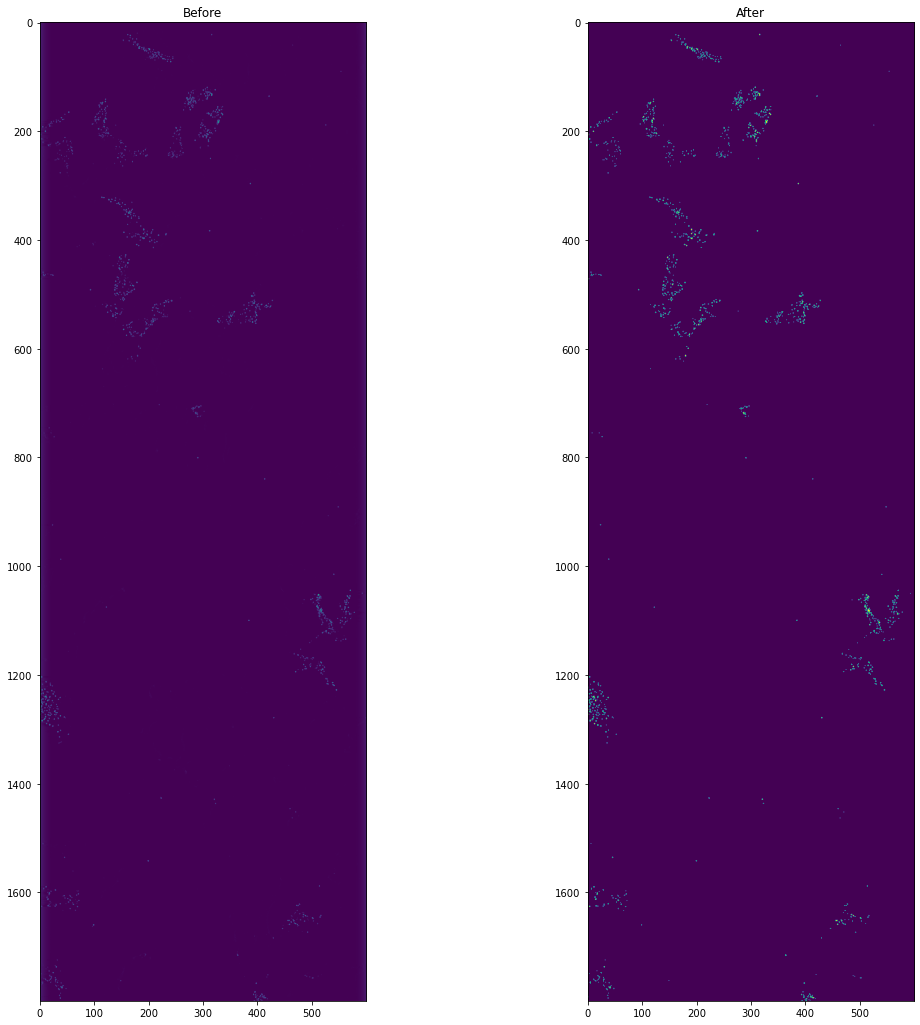

<Figure size 3000x2000 with 0 Axes>

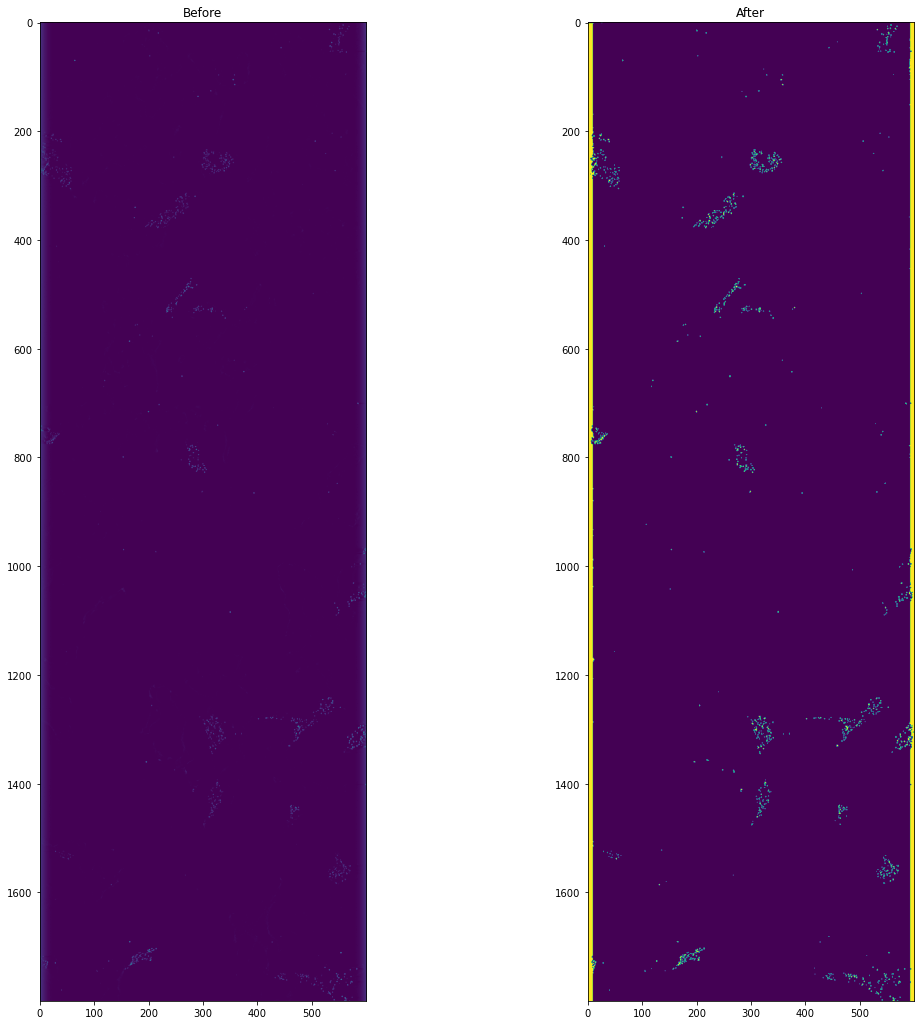

<Figure size 3000x2000 with 0 Axes>

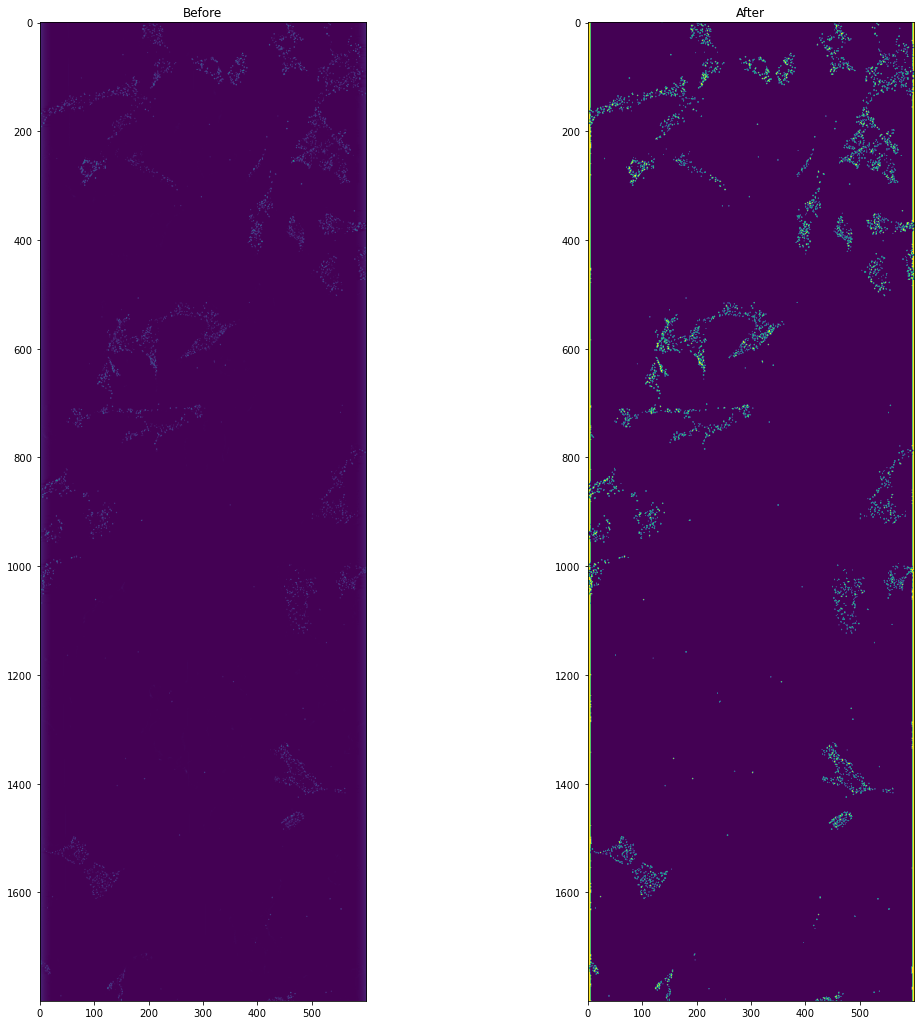

<Figure size 3000x2000 with 0 Axes>

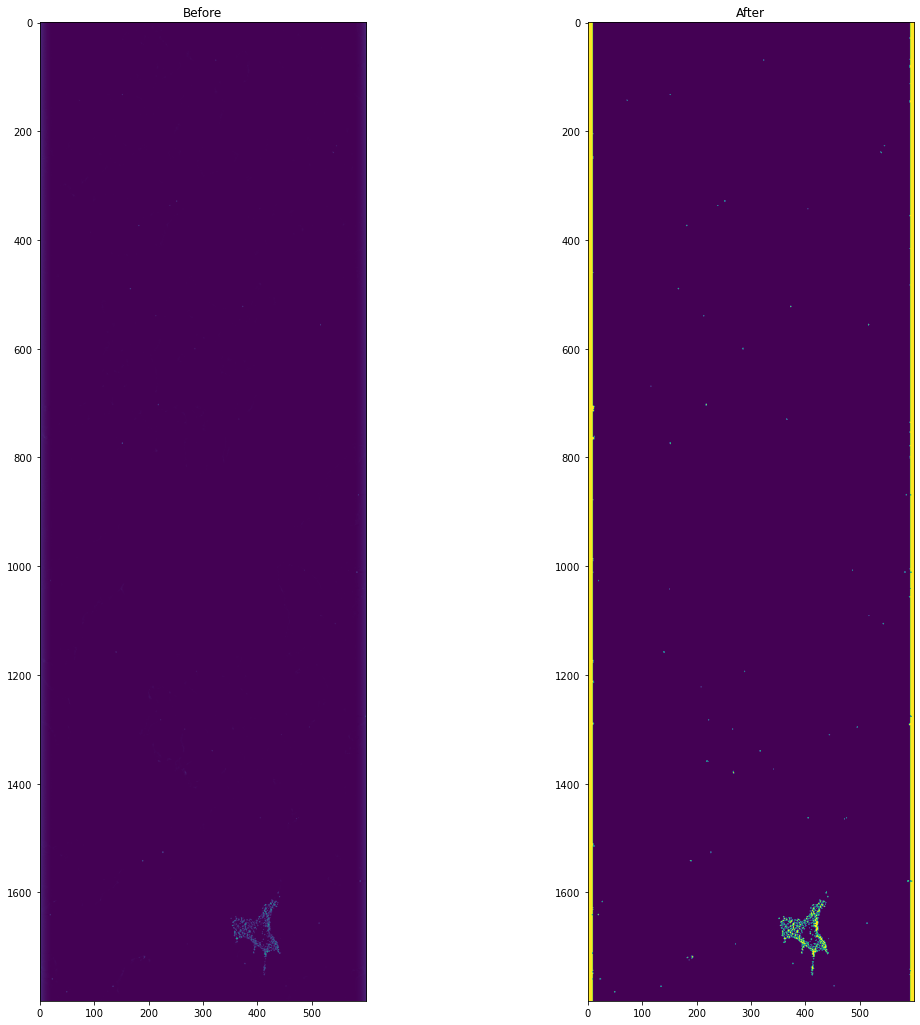

<Figure size 3000x2000 with 0 Axes>

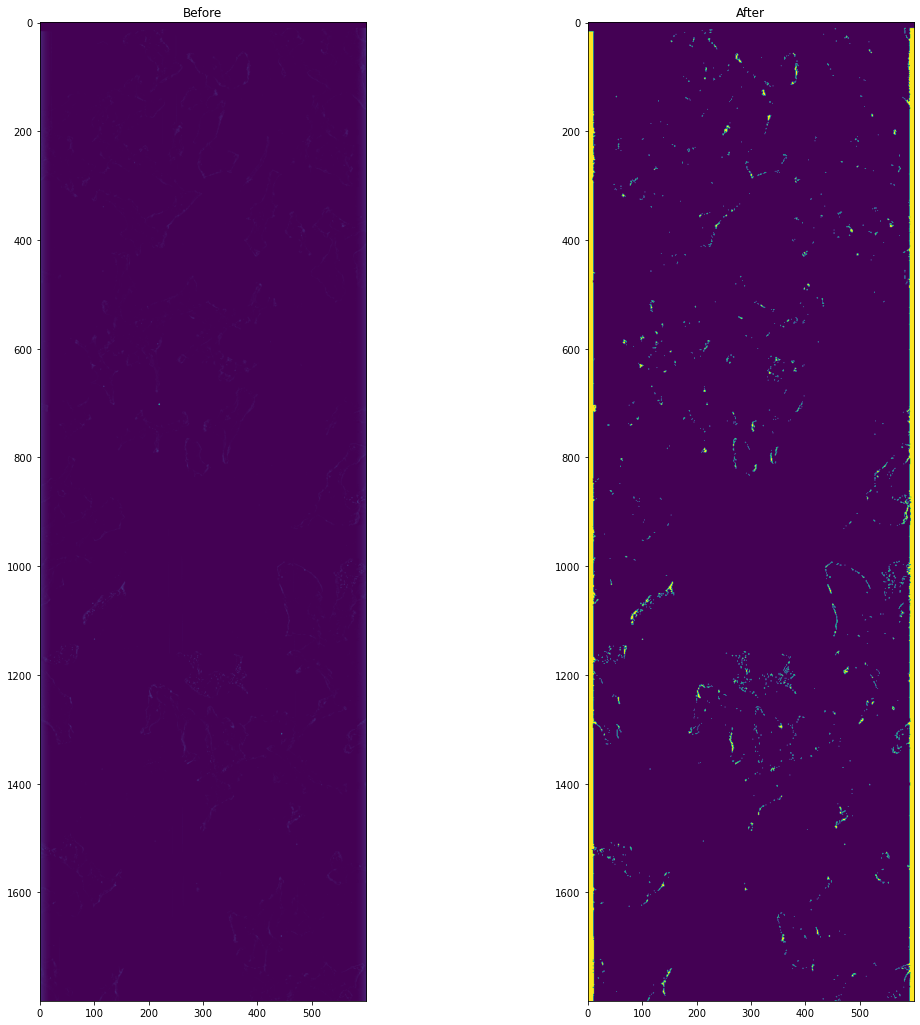

<Figure size 3000x2000 with 0 Axes>

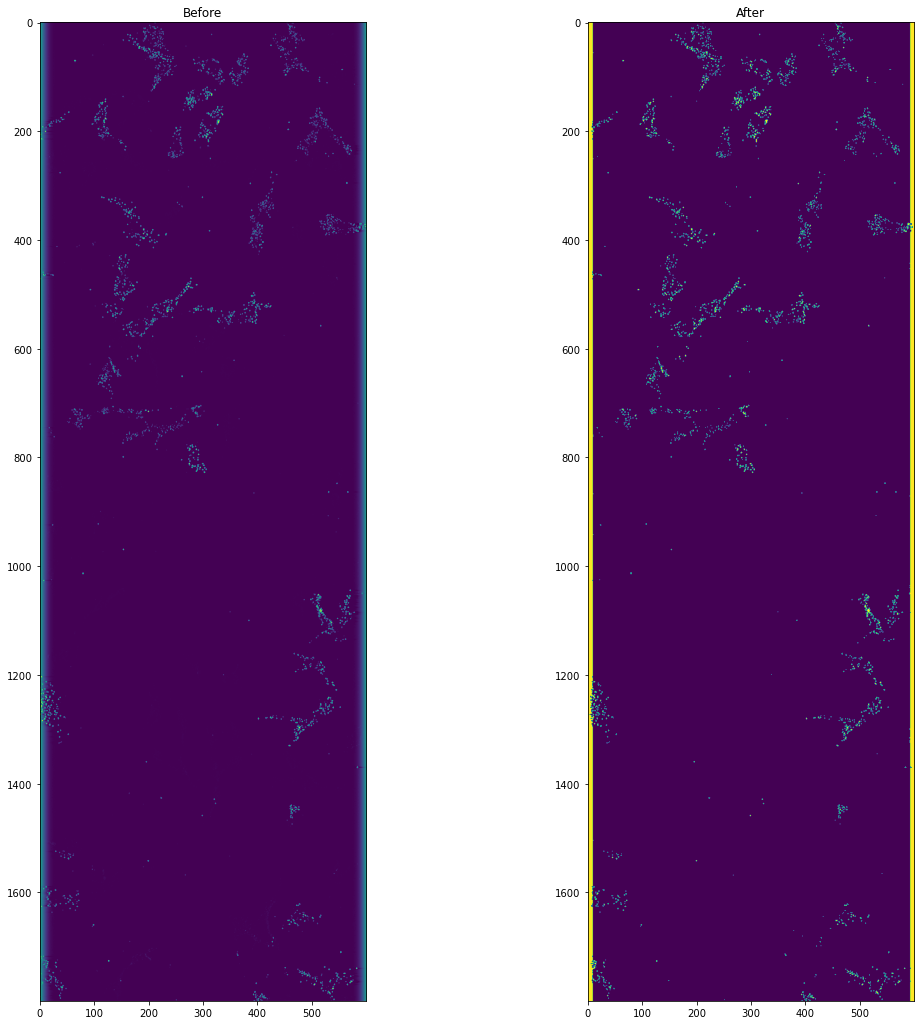

<Figure size 3000x2000 with 0 Axes>

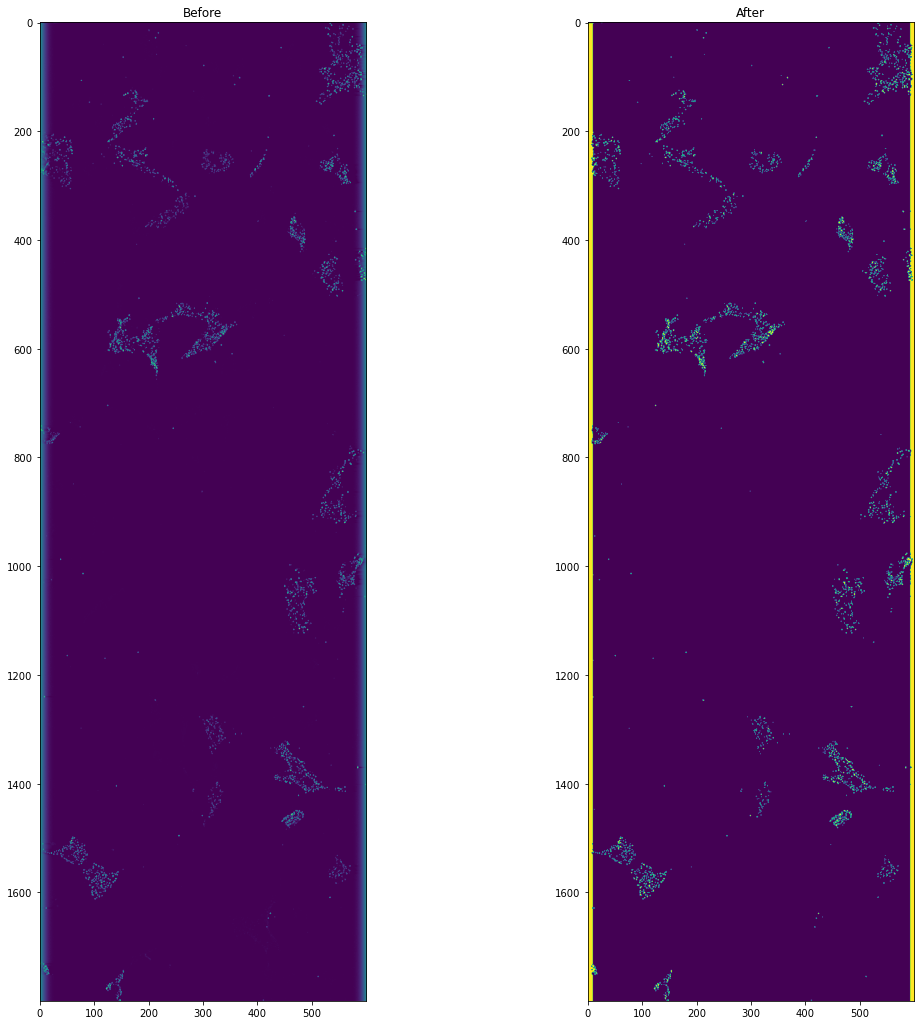

<Figure size 3000x2000 with 0 Axes>

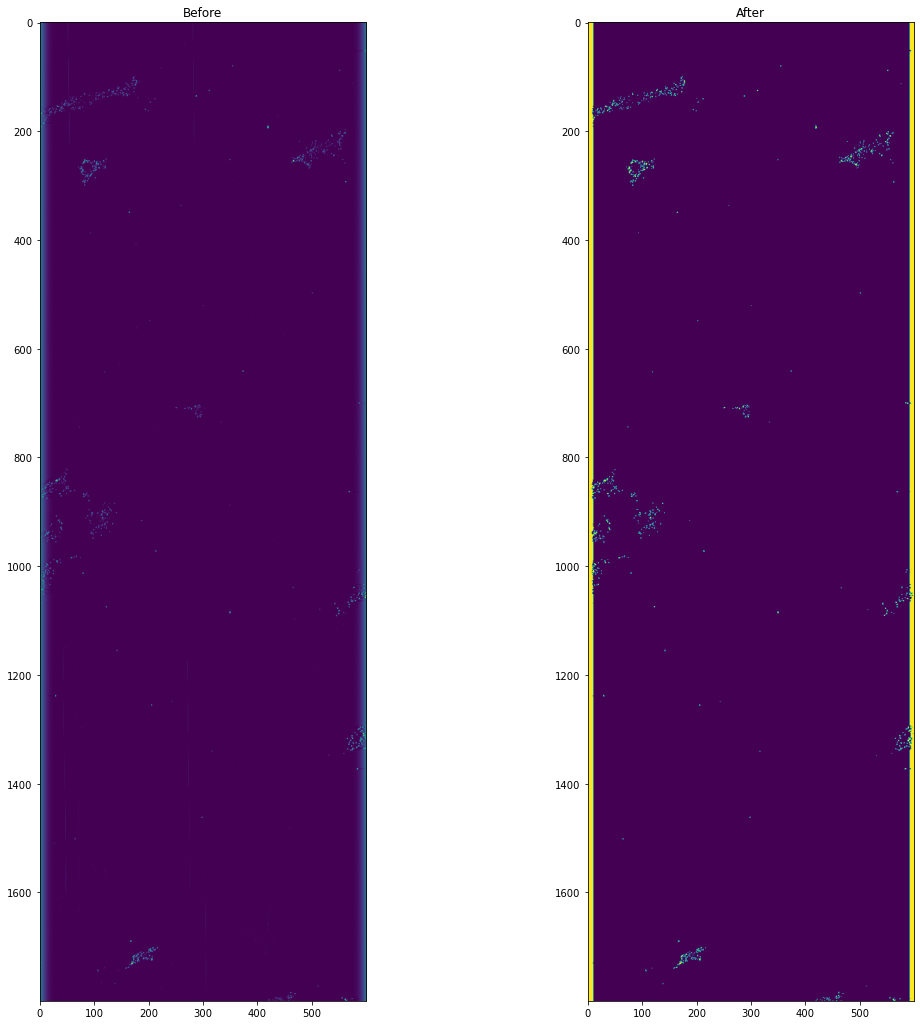

<Figure size 3000x2000 with 0 Axes>

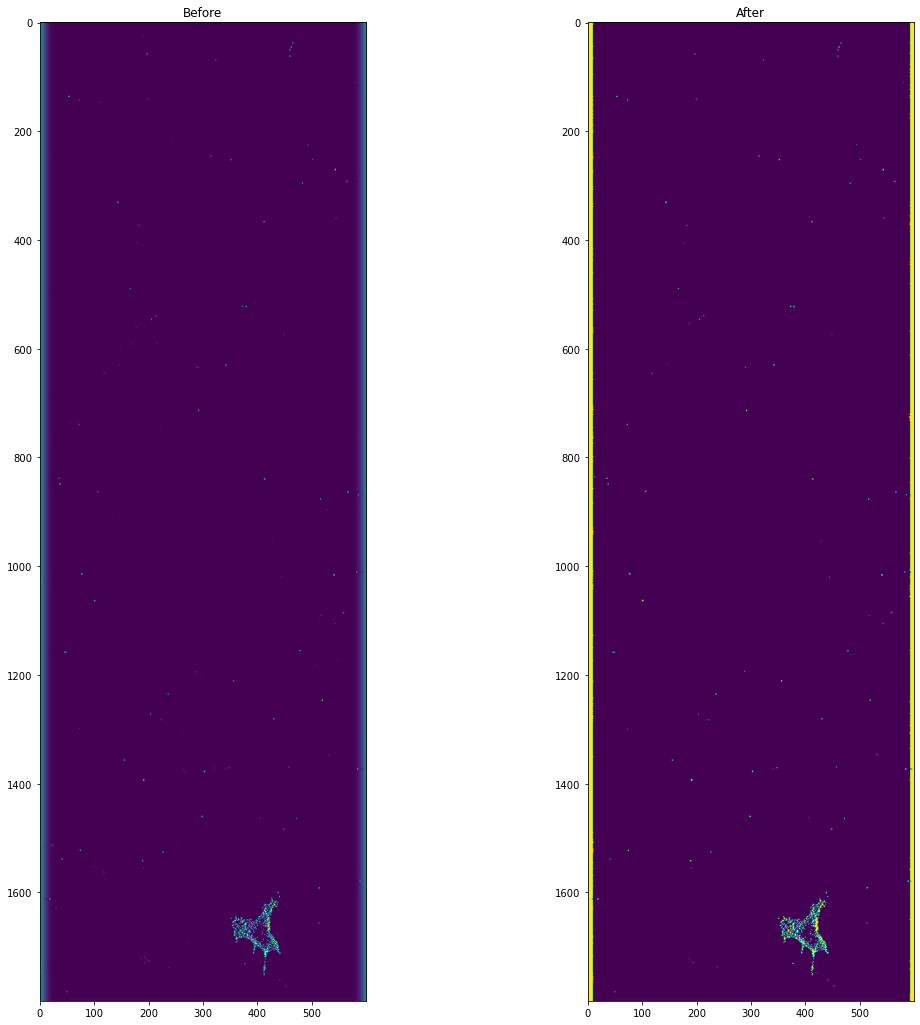

<Figure size 3000x2000 with 0 Axes>

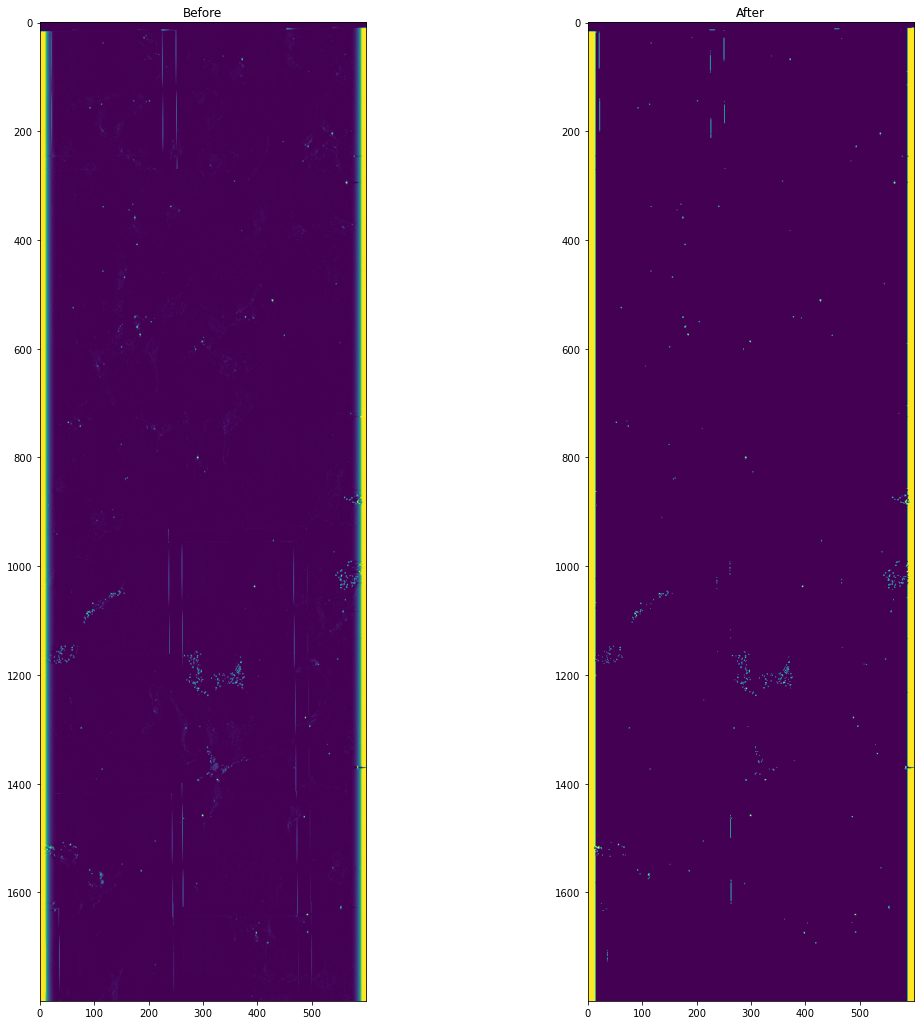

In [29]:
from skimage.filters import threshold_otsu
# Using threshold Yen on Xthresh which has been topped and stretched
# Xyen = np.zeros(Xthresh.shape)
for i in range(Xthresh.shape[0]):
    image = Xthresh[i, 0, ]
    thresh = threshold_otsu(image)
    binary = image > thresh
#     Xyen[i, 0, ] = binary
    
    plt.figure(dpi=500)
    fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Before')

    ax[1].imshow(binary)
    ax[1].set_title('After')

#     for a in ax:
#         a.axis('off')

    plt.show()

In [21]:
# # Before and after (partial region)
# # with bardensr.plotting.AnimAcross() as a:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=250)
#     plt.subplot(1, 2, 1)
# #     a('before')
#     plt.imshow(Xnorm[i, 0, 200:500, 200:500])
#     plt.subplot(1, 2, 2)
# #     a('after')
#     plt.imshow(Xthresh[i, 0, 200:500, 200:500])

# Peak calling and counting (inside membrane masks)

**Check by overlay to see if there are enough spots called.**

In [22]:
# Read in the membrane segmentation
with open('./data/20210714masks_mem.npy', 'rb') as m:
    masks_mem = np.load(m)

In [23]:
# plt.figure(dpi=250)
# plt.imshow(masks_mem)
# plt.axis('image')

In [24]:
# Find the number of membrane segmentation masks
# np.unique(masks_mem)

In [25]:
# # Check starting from which number the masks are truly membrane segmentation (instead of the background)
# plt.figure(dpi=300)
# for i in range(0, 5):
#     plt.figure()
#     plt.imshow(np.array(masks_mem)==i)

In [26]:
#     xindex = test.loc[i, 'm2'] + left
#     yindex = test.loc[i, 'm1'] + up

In [27]:
# pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))

In [28]:
# cell_table = pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))
cell_table = np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0]))

for k in range(Xthresh.shape[0]):  # for the kth image
    # Get local maximum values of desired neighborhood (size of the amplicons)
    max_fil = ndimage.maximum_filter(Xthresh[k,], size=(1, 2, 2))

    # Threshold the image to find locations of interest
    # assuming 6 standard deviations above the mean of the image
#     peak_thresh = max_fil.mean() + max_fil.std() * 6
    peak_thresh = 

    # find areas greater than peak_thresh
    labels, num_labels = ndimage.label(max_fil > peak_thresh)

    # Get the positions of the maxima
    coords = ndimage.measurements.center_of_mass(Xthresh[k,], 
                                                 labels=labels, 
                                                 index=np.arange(1, num_labels + 1))

    # # Get the maximum value in the labels
    # values = ndimage.measurements.maximum(img, labels=labels, index=np.arange(1, num_labels + 1))
    # # https://stackoverflow.com/questions/55453110/how-to-find-local-maxima-of-3d-array-in-python

    for _, m1, m2 in coords:
        m1 = int(np.round(m1))
        m2 = int(np.round(m2))
        mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
        if mem_id>0: # 0 is background
#             cell_table.loc[mem_id, k] += 1
            cell_table[mem_id, k] += 1

In [ ]:
# import DeCRISP as dcp
# cell_table = create_celltable(Xthresh, masks_mem, n_std=6, up_adjust=up, left_adjust=left)
# cell_table

In [29]:
# labels

In [30]:
num_labels

23

In [31]:
coords[:10]

[(0.0, 68.0, 560.5573801072194),
 (0.0, 204.47960808540344, 726.0000000000001),
 (0.0, 294.52533383822083, 752.0),
 (0.0, 359.00000000000006, 363.5323809594711),
 (0.0, 511.39103510804983, 616.0),
 (0.0, 547.4239122409541, 968.5674409377059),
 (0.0, 574.0, 373.0),
 (0.0, 659.5695841146683, 844.8773322175192),
 (0.0, 711.0, 822.0),
 (0.0, 800.4277594728355, 478.99999999999994)]

In [32]:
int(np.round(801.5228444869555))

802

In [33]:
len(coords)

23

In [34]:
np.max(cell_table)

124.0

In [35]:
pd.DataFrame(cell_table)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,7.0,3.0,0.0,1.0,1.0,7.0,4.0,0.0,0.0
3,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
4,1.0,1.0,25.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [37]:
cell_table.shape

(336, 10)

# Nearest Neighbor/Correlation

In [38]:
# Calculate the correlation
cell_norm = np.sqrt(np.sum(np.power(cell_table, 2), axis=1))
cell_corr = cell_table.dot(codebook.T) / np.reshape(cell_norm + 1e-6, (-1,1))  # add 1e-6 to avoid the denominator being 0

In [39]:
cell_corr

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.999999  ,
        0.        ],
       [0.17817415, 0.        , 1.24721902, ..., 0.71269658, 0.89087073,
        0.9799578 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
cell_corr.shape

(336, 10)

In [41]:
# cell_norm + 1e-6

In [42]:
# (cell_table.dot(codebook.T) / np.reshape(cell_norm, (-1,1))).shape

In [43]:
# cell_norm

In [44]:
# np.reshape(cell_norm, (-1,1))

In [45]:
def argmax_thresh(a, axis, thresh):
#     rows = np.where(a == a.max(axis=1)[:, None])[0]
    rows_too_small = np.where(np.max(a, axis=1) < thresh)
    my_argmax = a.argmax(axis=axis)
    my_argmax[rows_too_small] = -1
    return my_argmax
# https://stackoverflow.com/questions/51318081/numpy-argmax-when-values-are-equal

In [46]:
# Assign cells to barcodes according to the max correlation
# cell_id = pd.DataFrame(np.argmax(cell_corr, axis=1), columns=['barcode'])
corr_thresh = 0.1
cell_id = pd.DataFrame(argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id

,barcode
0,-1
1,4
2,2
3,0
4,6
...,...
331,-1
332,-1
333,-1
334,-1


In [53]:
# temp = cell_id.copy()
# temp['group'] = np.zeros(temp.shape[0])
# temp.group[temp.barcode.isin([0, 1, 2, 3, 4])] = 'GFP'
# temp.group[temp.barcode>4] = 'NTC'
# temp

,barcode
0,-1
1,4
2,2
3,0
4,6
...,...
331,-1
332,-1
333,-1
334,-1


In [ ]:
plt.style.use('seaborn-ticks')

plt.figure(figsize=(8,6))
plt.hist(gfp_0621['Avg GFP Nuclei'],bins=100, alpha=0.5, label="GFP")
plt.hist(ntc_0621['Avg GFP Nuclei'],bins=100, alpha=0.5, label="NTC")
# plt.hist(unassigned_0621['Avg GFP Nuclei'],bins=100, alpha=0.5, label="Unassigned") # uncomment to plot unassigned cells

plt.xlabel("Nuclei Average GFP", size=11)
plt.ylabel("Count", size=11)
plt.title("Nuclei Average GFP")
plt.legend(loc='upper right')

In [45]:
# cell_id.loc[200:210]

In [26]:
# cell_id.to_csv('./result/crisprmap20210714sg2NEB_picklemax_cell_id_thresh6std_minusone.csv', index=False)

In [47]:
heapq.nlargest(2, cell_corr[116,])

[1.183215756619957, 1.183215756619957]

In [48]:
def minmax(x, min_all, max_all):
    y = (x-min_all)/max_all
    return y

In [75]:
cell_id['max'] = minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['second_max'] = minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
# cell_id['second_max'] = [heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index]
cell_id['quality'] = cell_id['max'] - cell_id['second_max']
cell_id['spots'] = np.sum(cell_table, axis=1)
# cell_id = cell_id.sort_values(by=['quality'], ascending=False)
cell_id

,barcode,max,second_max,quality,spots
0,0,0.000000,0.000000,0.000000,0.0
1,0,0.000000,0.000000,0.000000,0.0
2,4,0.852803,0.852803,0.000000,5.0
3,0,0.000000,0.000000,0.000000,0.0
4,0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...
655,0,0.872595,0.668989,0.203605,47.0
656,9,0.994736,0.539999,0.454736,39.0
657,5,0.923870,0.710669,0.213201,19.0
658,4,0.993146,0.574979,0.418167,21.0


In [76]:
# cell_id.head(40)

In [67]:
pd.DataFrame(cell_table).loc[406,]

0    0.0
1    0.0
2    0.0
3    4.0
4    0.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: 406, dtype: float64

In [69]:
np.sum(cell_table, axis=1).shape

(660,)

In [80]:
cell_id.sort_values(by=['spots'], ascending=False).head(20)

,barcode,max,second_max,quality,spots
555,4,0.998070,0.528892,0.469178,125.0
125,4,0.757896,0.708198,0.049698,117.0
504,8,0.875905,0.841779,0.034126,108.0
405,6,0.958857,0.620437,0.338420,106.0
604,6,0.953074,0.673367,0.279706,103.0
328,6,0.840318,0.713477,0.126840,95.0
443,6,0.967186,0.636927,0.330259,94.0
306,9,0.939793,0.740443,0.199350,90.0
550,8,0.862507,0.847636,0.014871,89.0
379,6,0.896262,0.687544,0.208719,85.0


In [81]:
cell_id.sort_values(by=['quality'], ascending=False).head(20)

,barcode,max,second_max,quality,spots
291,1,0.938876,0.000000,0.938876,60.0
406,1,0.857493,0.000000,0.857493,5.0
359,1,0.923846,0.074906,0.848940,40.0
98,1,0.920358,0.076696,0.843661,26.0
156,1,0.925711,0.100987,0.824724,67.0
118,1,0.925208,0.102801,0.822407,43.0
83,1,0.904194,0.082199,0.821995,12.0
283,1,0.920980,0.099565,0.821414,43.0
299,1,0.927498,0.132500,0.794998,42.0
380,1,0.880812,0.091119,0.789694,36.0


<AxesSubplot:xlabel='quality', ylabel='Count'>

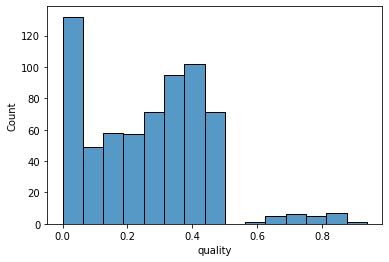

In [50]:
import seaborn as sns
sns.histplot(data=cell_id, x="quality")

<AxesSubplot:xlabel='max', ylabel='Count'>

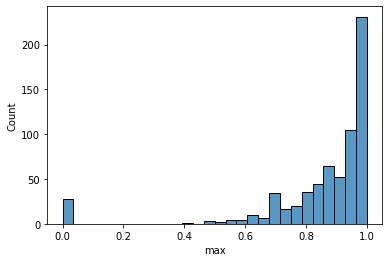

In [51]:
import seaborn as sns
sns.histplot(data=cell_id, x="max")

<AxesSubplot:xlabel='second_max', ylabel='Count'>

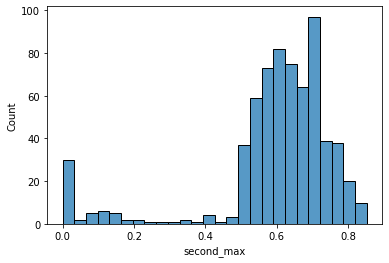

In [52]:
import seaborn as sns
sns.histplot(data=cell_id, x="second_max")

In [53]:
cell_id[cell_id['quality']>0.7]

,barcode,max,second_max,quality
291,1,0.938876,0.000000,0.938876
406,1,0.857493,0.000000,0.857493
359,1,0.923846,0.074906,0.848940
98,1,0.920358,0.076696,0.843661
156,1,0.925711,0.100987,0.824724
118,1,0.925208,0.102801,0.822407
83,1,0.904194,0.082199,0.821995
283,1,0.920980,0.099565,0.821414
299,1,0.927498,0.132500,0.794998
380,1,0.880812,0.091119,0.789694


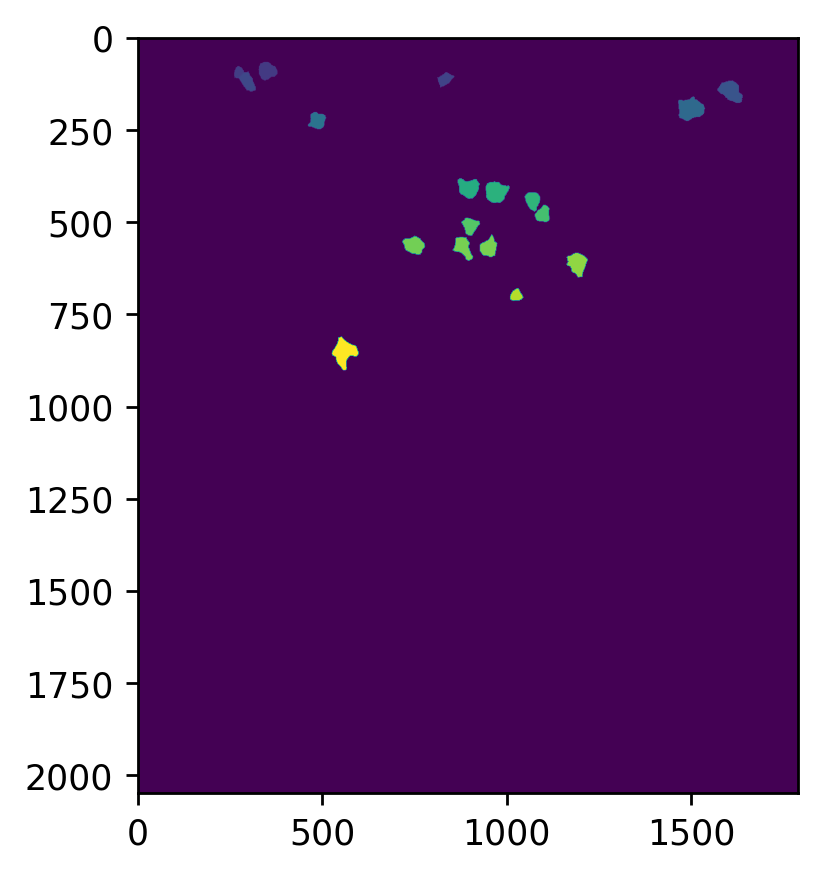

In [54]:
# Possibly plot which cells have high quality scores
high_quality = cell_id[cell_id['quality']>0.7]
high_quality_mem = np.zeros(masks_mem.shape)
for i in high_quality.index:
    high_quality_mem[np.array(masks_mem)==i] = i
plt.figure(dpi=250)
plt.imshow(high_quality_mem)

In [55]:
# sns.histplot(data=cell_id, x="max")

In [82]:
# set(cell_id['max'])

In [57]:
np.max(cell_corr)

1.4142134909445272

In [58]:
cell_corr.shape

(660, 10)

<AxesSubplot:xlabel='spots', ylabel='Count'>

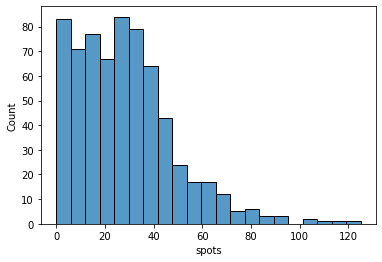

In [83]:
sns.histplot(data=cell_id, x="spots")

<!-- list1 = [10, 20, 4, 45, 99]
 
# new_list is a set of list1
new_list = set(list1)
 
# removing the largest element from temp list
new_list.remove(max(new_list))
 
# elements in original list are not changed
# print(list1)
 
print(max(new_list)) -->